In [29]:
import pandas as pd
import torch
from transformers import pipeline
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [30]:
# Load Cleaned Data
df = pd.read_csv("../scraped_reviews/cleaned_reviews.csv")
df.head()

,review_text,rating,date,bank_name,source
0,"Hello, I’m facing a problem with the BOA Mobil...",1,2025-06-03,Bank of Abyssinia,Google Play
1,this is worest app 24/7 loading,1,2025-06-01,Bank of Abyssinia,Google Play
2,This App is not interest for Android phone Ple...,1,2025-06-01,Bank of Abyssinia,Google Play
3,BoA system is confartable,5,2025-06-01,Bank of Abyssinia,Google Play
4,"this app, for me , is a waste of time. It does...",1,2025-05-27,Bank of Abyssinia,Google Play


In [32]:
# Load DistilBERT Sentiment Pipeline
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=device)

Device set to use cpu


In [33]:
# Predict Sentiment
def get_sentiment_label_with_neutral(text, threshold_low=0.45, threshold_high=0.55):
    try:
        result = classifier(text[:512])[0]
        label = result['label'].lower()
        score = result['score']

        # Add a neutral zone
        if threshold_low < score < threshold_high:
            return 'neutral'
        else:
            return label
    except:
        return "neutral"


df['sentiment'] = df['review_text'].apply(get_sentiment_label_with_neutral)
df['sentiment'].value_counts()

sentiment
positive    1806
negative    1585
neutral       11
Name: count, dtype: int64

In [34]:
# Map sentiment to numeric: positive=1, neutral=0, negative=-1
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

# Aggregate
mean_sentiment = df.groupby(['bank_name', 'rating'])['sentiment_score'].mean().reset_index()
mean_sentiment.columns = ['bank_name', 'rating', 'mean_sentiment']
mean_sentiment.sort_values(['bank_name', 'rating'], inplace=True)
mean_sentiment

,bank_name,rating,mean_sentiment
0,Bank of Abyssinia,1,-0.856305
1,Bank of Abyssinia,2,-0.897436
2,Bank of Abyssinia,3,-0.644444
3,Bank of Abyssinia,4,0.037037
4,Bank of Abyssinia,5,0.531250
5,Commercial Bank of Ethiopia,1,-0.790698
6,Commercial Bank of Ethiopia,2,-0.694444
7,Commercial Bank of Ethiopia,3,-0.516304
8,Commercial Bank of Ethiopia,4,0.076923
9,Commercial Bank of Ethiopia,5,0.657544


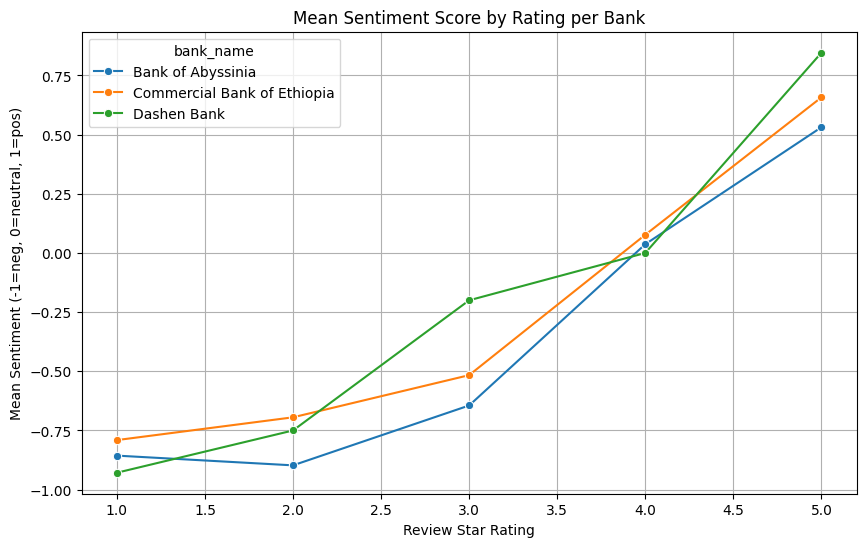

In [35]:
plt.figure(figsize=(10,6))
sns.lineplot(data=mean_sentiment, x='rating', y='mean_sentiment', hue='bank_name', marker="o")
plt.title("Mean Sentiment Score by Rating per Bank")
plt.ylabel("Mean Sentiment (-1=neg, 0=neutral, 1=pos)")
plt.xlabel("Review Star Rating")
plt.grid(True)
plt.show()

In [36]:
# Create a deep copy
df_copy = df.copy()

Thematic Analysis

In [ ]:
# NLP Preprocessing
nlp = spacy.load("en_core_web_sm")

# uses lemmatization in bad way and removes words like "not"

def clean_text(text):
    doc = nlp(str(text).lower())
    return ' '.join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

df_copy['cleaned_text'] = df_copy['review_text'].apply(clean_text)

,review_text,cleaned_text
3426,Too difficult to sign in.,difficult sign


In [28]:
df_copy[['review_text', 'cleaned_text']].head()

,review_text,cleaned_text
0,it's not working,work
1,"Hello, I’m facing a problem with the BOA Mobil...",hello face problem boa mobile app time enter p...
2,exceptional,exceptional
3,BoA Mobile good bank,boa mobile good bank
4,this is worest app 24/7 loading,wor app 24/7 loading


In [ ]:
# NLP Preprocessing
nlp = spacy.load("en_core_web_sm")

# keeps 'not' but lemma is bad
custom_stopwords = STOP_WORDS - {"not"}

def clean_text(text):
    doc = nlp(str(text).lower())
    return ' '.join(
        token.lemma_ for token in doc
        if token.text not in custom_stopwords and not token.is_punct
    )

df_copy['cleaned_text'] = df_copy['review_text'].apply(clean_text)

In [37]:
# TO BE KEEPED
# NLP Preprocessing
nlp = spacy.load("en_core_web_sm")

# Custom stopwords – keep negations like "not", "no", "never"
custom_stopwords = STOP_WORDS - {"not", "no", "never"}

def clean_text(text):
    doc = nlp(str(text).lower())
    return ' '.join(
        token.text for token in doc
        if token.text not in custom_stopwords and not token.is_punct
    )

df_copy['cleaned_text'] = df_copy['review_text'].apply(clean_text)

In [38]:
df_copy[['review_text', 'cleaned_text']].head()

,review_text,cleaned_text
0,"Hello, I’m facing a problem with the BOA Mobil...",hello facing problem boa mobile app time enter...
1,this is worest app 24/7 loading,worest app 24/7 loading
2,This App is not interest for Android phone Ple...,app not interest android phone update
3,BoA system is confartable,boa system confartable
4,"this app, for me , is a waste of time. It does...",app waste time work long piss fix problem


TF-IDF Keyword Extraction

In [39]:
# Use both single words and common two-word phrases
tfidf = TfidfVectorizer(
    max_features=50,         # top 50 features
    ngram_range=(2, 3),      # include unigrams and bigrams
    stop_words=None          # we've already cleaned text
)

X = tfidf.fit_transform(df_copy['cleaned_text'])

# Extract top keywords
keywords = tfidf.get_feature_names_out()
print("🔑 Top TF-IDF keywords:\n", keywords)

🔑 Top TF-IDF keywords:
 ['amazing app' 'app easy' 'app good' 'app like' 'app not'
 'app not working' 'bank ethiopia' 'bank super' 'banking app' 'best app'
 'best application' 'best mobile' 'best mobile banking' 'cbe app'
 'cbe mobile' 'commercial bank' 'commercial bank ethiopia' 'dashen bank'
 'dashen bank super' 'dashen super' 'dashen super app' 'developer mode'
 'developer option' 'developer options' 'easy fast' 'easy use' 'fast easy'
 'good app' 'good application' 'great app' 'like app' 'mobile app'
 'mobile banking' 'mobile banking app' 'new update' 'nice app' 'not work'
 'not working' 'send money' 'simple use' 'step ahead' 'super app'
 'transaction history' 'transfer money' 'turn developer' 'update app'
 'use app' 'user friendly' 'worst app' 'worst mobile']


In [40]:
keyword_scores = np.asarray(X.sum(axis=0)).flatten()
tfidf_scores = pd.DataFrame({
    'keyword': keywords,
    'score': keyword_scores
}).sort_values(by='score', ascending=False)

tfidf_scores.head(10)

,keyword,score
27,good app,114.307120
25,easy use,95.290117
32,mobile banking,94.536513
37,not working,88.064200
9,best app,70.593331
35,nice app,62.275359
4,app not,54.996249
8,banking app,50.884603
47,user friendly,44.344235
29,great app,37.296035


In [41]:
print(df_copy.columns)

Index(['review_text', 'rating', 'date', 'bank_name', 'source', 'sentiment',
       'sentiment_score', 'cleaned_text'],
      dtype='object')


In [42]:
# Create Document-Term Matrix with CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=5)
dtm = vectorizer.fit_transform(df_copy['cleaned_text'])


In [43]:
# Fit LDA Model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

,n_components,5
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [44]:
# Show Top Keywords per Topic
def display_topics(model, feature_names, num_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-num_top_words:][::-1]]))

feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names)


Topic 1:
app, update, not, fix, new, work, developer, problem, banking, use

Topic 2:
app, money, account, bank, transfer, worst, cbe, time, telebirr, like

Topic 3:
transaction, app, time, transactions, good, version, better, no, work, history

Topic 4:
app, good, best, use, easy, bank, banking, fast, application, mobile

Topic 5:
not, app, working, nice, application, user, bad, good, thanks, service


In [45]:
# Assign Topic to Each Review
topic_distribution = lda.transform(dtm)
df_copy['assigned_topic'] = topic_distribution.argmax(axis=1)

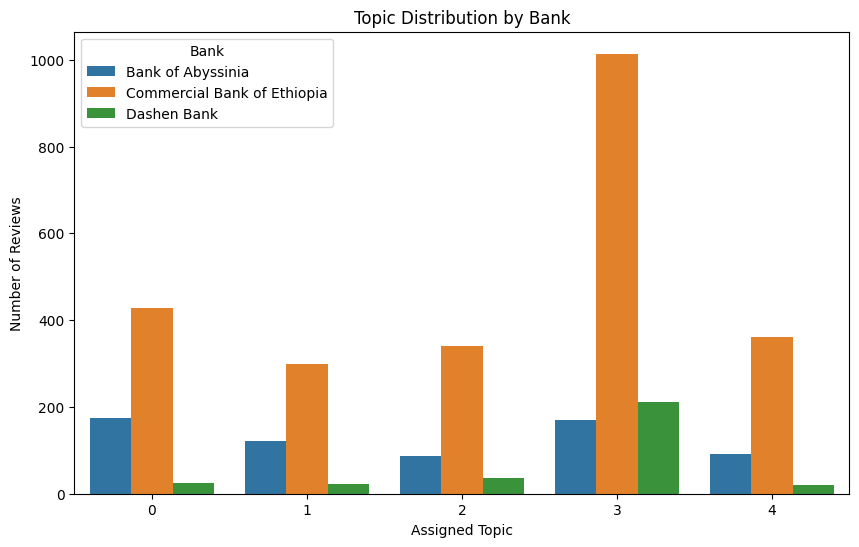

In [46]:
# Per-Bank Topic Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='assigned_topic', hue='bank_name')
plt.title("Topic Distribution by Bank")
plt.xlabel("Assigned Topic")
plt.ylabel("Number of Reviews")
plt.legend(title="Bank")
plt.show()

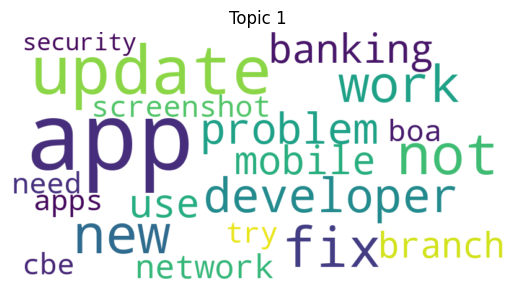

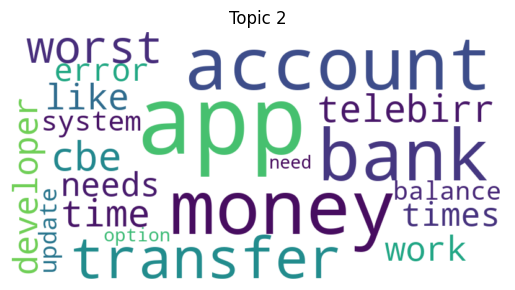

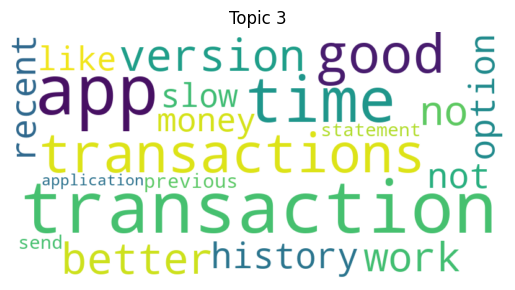

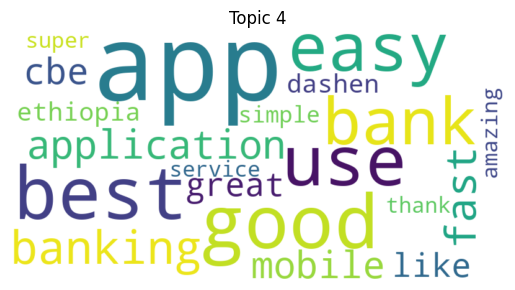

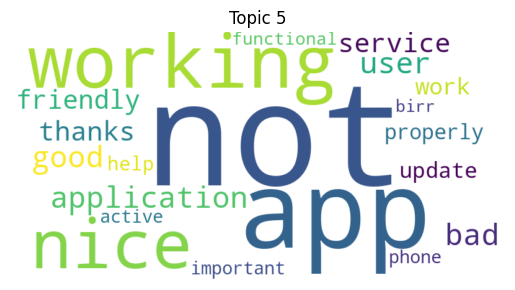

In [48]:
from wordcloud import WordCloud

for topic_idx, topic in enumerate(lda.components_):
    plt.figure()
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies({feature_names[i]: topic[i] for i in topic.argsort()[-20:]})
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()

In [50]:
df_copy.columns

Index(['review_text', 'rating', 'date', 'bank_name', 'source', 'sentiment',
       'sentiment_score', 'cleaned_text', 'assigned_topic'],
      dtype='object')

In [52]:
df_copy.head()

,review_text,rating,date,bank_name,source,sentiment,sentiment_score,cleaned_text,assigned_topic
0,"Hello, I’m facing a problem with the BOA Mobil...",1,2025-06-03,Bank of Abyssinia,Google Play,negative,-1,hello facing problem boa mobile app time enter...,0
1,this is worest app 24/7 loading,1,2025-06-01,Bank of Abyssinia,Google Play,negative,-1,worest app 24/7 loading,2
2,This App is not interest for Android phone Ple...,1,2025-06-01,Bank of Abyssinia,Google Play,negative,-1,app not interest android phone update,4
3,BoA system is confartable,5,2025-06-01,Bank of Abyssinia,Google Play,negative,-1,boa system confartable,0
4,"this app, for me , is a waste of time. It does...",1,2025-05-27,Bank of Abyssinia,Google Play,negative,-1,app waste time work long piss fix problem,2


In [53]:
df_copy.to_csv("../scraped_reviews/analysed_reviews.csv", index=False)
print("✅ Cleaned dataset saved as 'analysed_reviews.csv'")

✅ Cleaned dataset saved as 'analysed_reviews.csv'
